# CSE 343 Machine Learning A-1

## Q2 Logistic Regression

### Preprocessing and EDA

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("diabetes2.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Text(0.5, 1.0, 'Age Distribution')

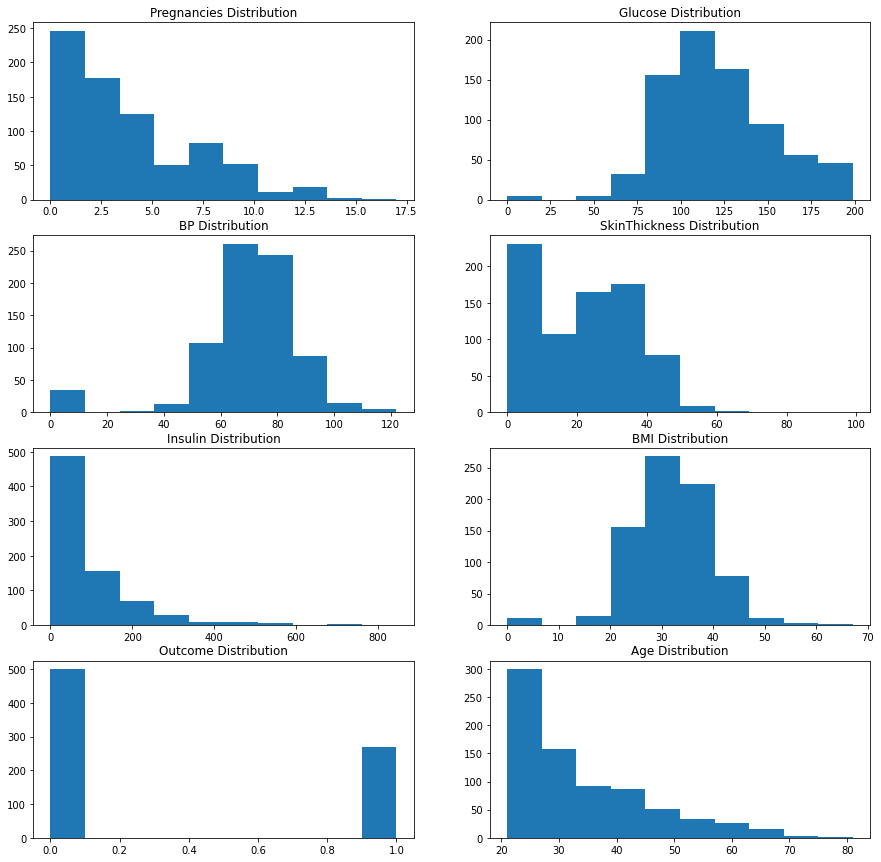

In [2]:
## creating plots for different columns

plt.rcParams["figure.figsize"] = (15,15)
fig,axs = plt.subplots(4,2)

axs[0,0].hist(df["Pregnancies"])
axs[0,0].set_title("Pregnancies Distribution")

axs[0,1].hist(df["Glucose"])
axs[0,1].set_title("Glucose Distribution")

axs[1,0].hist(df["BloodPressure"])
axs[1,0].set_title("BP Distribution")

axs[1,1].hist(df["SkinThickness"])
axs[1,1].set_title("SkinThickness Distribution")

axs[2,0].hist(df["Insulin"])
axs[2,0].set_title("Insulin Distribution")

axs[2,1].hist(df["BMI"])
axs[2,1].set_title("BMI Distribution")

axs[3,0].hist(df["Outcome"])
axs[3,0].set_title("Outcome Distribution")

axs[3,1].hist(df["Age"])
axs[3,1].set_title("Age Distribution")



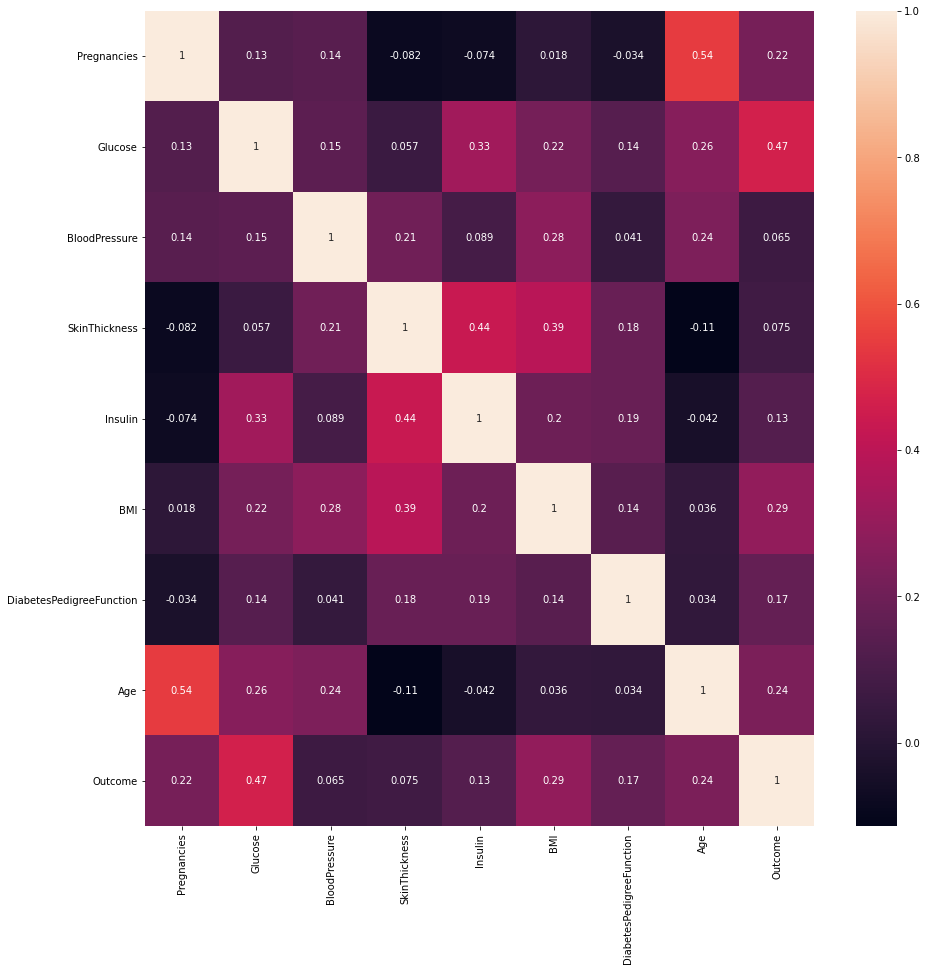

In [3]:
## creating correlation matrix for the dataset
ax = sns.heatmap(df.corr(), annot=True)

### 2.1 Running Self Implemented Logistic Regression using SGD and BGD

In [22]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

t = []
v = []

## class implementing Stochastic Gradient Descent
class SGD:
    
    coeff_matrix=None
    alpha=None
    num_iterations=None
    num_features=None
    num_training_points=None
    
    def __init__(self, alpha, num_iterations, num_features, num_training_points):
        
        ## num features incl c
        coeff=[0 for i in range(num_features)]
        coeff[num_features-1]=0
        
        self.coeff_matrix=np.array(coeff)
        
        self.alpha=alpha
        self.num_iterations=num_iterations
        self.num_features=num_features
        self.num_training_points=num_training_points
        
    ## sigmoid function
    def sigmoid(self,x):
        
        if x>50:
            return 0.99999999
        if x<-100:
            return 0.00000001
        
        return 1/(1+np.exp(-x))
        
    def step_gd(self, x, y, x_val, y_val):
           
        for i in range(self.num_training_points):
            
            X = x[i]
            Y = y[i]
            
            arg = (X*self.coeff_matrix).sum()
            pred = self.sigmoid(arg)
            
           
            ##cost = (-1/self.num_training_points)*((Y*np.log(pred+10e-32) + (1-Y)*np.log(1-pred+10e-32)).sum())
                
            if(len(t)<2000):
                t.append(self.cost(x,y))
                v.append(self.cost(x_val,y_val))
            grad = (-1/self.num_training_points)*((Y-pred)*X)
              
            ## in SGD, we update gradient for every training point, rather than for the whole chunk
            self.coeff_matrix = self.coeff_matrix - self.alpha*grad
            
    
    def sigmoid2(self,x):
        
        x[x>50]=50
        x[x<-100]=-100
        return 1/(1+np.exp(-x))
    
   
    def cost(self, x, y):
        
        arg = np.sum(x*self.coeff_matrix,axis=1)
        pred = self.sigmoid2(arg)
        
        ## adding a 10e-32 just in case pred -> 1 for large values
        cost = (-1/x.shape[0])*((y*np.log(pred+10e-32)+(1-y)*np.log(1-pred+10e-32)).sum())
        return cost
       
    def run_gd(self, x, y, x_val, y_val):
        
        for i in range(self.num_iterations):
            self.step_gd(x,y,x_val,y_val)
            if (i+1)%20==0:
                print("iteration:",i+1,":",self.cost(x, y))
           
    ## prediction function, rounds of values to 0 or 1
    def predict(self, x):
        
        y = []
        
        for row in x:
            ans=self.sigmoid(np.matmul(row,self.coeff_matrix).sum())
            if ans<=0.5:
                y.append(0)
            else:
                y.append(1)
        
        return y

In [23]:
## class for batch gradient descent which updates gradients in chunks
t = []
v = []
class BGD:
    
    coeff_matrix=None
    alpha=None
    num_iterations=None
    num_features=None
    num_training_points=None
    
    def __init__(self, alpha, num_iterations, num_features, num_training_points):
        
        ## num features incl c
        coeff=[0 for i in range(num_features)]
        coeff[num_features-1]=0
        
        self.coeff_matrix=np.array(coeff)
        
        self.alpha=alpha
        self.num_iterations=num_iterations
        self.num_features=num_features
        self.num_training_points=num_training_points
        
    def sigmoid(self,x):
            
        if x>50:
            return 0.99999999
        if x<-100:
            return 0.00000001
        
        return 1/(1+np.exp(-x))
        
    def step_gd(self, x, y, x_val, y_val):
           
        grad = np.zeros(self.num_features)
       
        for i in range(self.num_training_points):
            
            X = x[i]
            Y = y[i]
            
            arg = (X*self.coeff_matrix).sum()
            pred = self.sigmoid(arg)
            
            #if pred==1:
             #   continue
                
            #cost = (-1/self.num_training_points)*((Y*np.log(pred+10e-32) + (1-Y)*np.log(1-pred+10e-32)).sum())
            
            
                
            grad += (-1/self.num_training_points)*((Y-pred)*X)
            
        ## updating gradient outside the for loop, for the whole dataset  
        if(len(t)<2000):
            t.append(self.cost(x,y))
            v.append(self.cost(x_val,y_val))
            
        self.coeff_matrix = self.coeff_matrix - self.alpha*grad
            
            
    def sigmoid2(self,x):
        
        x[x>50]=50
        x[x<-100]=-100
        return 1/(1+np.exp(-x))
    
    def cost(self, x, y):
        
        arg = np.sum(x*self.coeff_matrix,axis=1)
        pred = self.sigmoid2(arg)
        cost = (-1/x.shape[0])*((y*np.log(pred+10e-32)+(1-y)*np.log(1-pred+10e-32)).sum())
        return cost
       
    def run_gd(self, x, y, x_val, y_val):
        
        for i in range(self.num_iterations):
            self.step_gd(x,y,x_val,y_val)
            if (i+1)%20==0:
                print("iteration:",i+1,":",self.cost(x, y))
            
    def predict(self, x):
        
        y = []
        
        for row in x:
            ans=self.sigmoid(np.matmul(row,self.coeff_matrix).sum())
            if ans<=0.5:
                y.append(0)
            else:
                y.append(1)
        
        return y

In [24]:
## function to calculate mean accuracy and confusion matrix
def score(y,y_pred):
    
    c=0
    for i in range(len(y)):
        if y[i]==y_pred[i]:
            c+=1
            
    return c/len(y)

def confusionMatrix(y,y_pred):
    
    TP=0
    FP=0
    TN=0
    FN=0
    
    for i in range(len(y)):
        
        if y[i]==y_pred[i]:
            if y[i]==1:
                TP+=1
            else:
                TN+=1
        else:
            if y_pred[i]==0:
                FN+=1
            else:
                FP+=1 
    
    ## negative=0, positive=1
    prec_0 = TN/(TN+FN)
    recall_0 = TN/(TN+FP)
    prec_1 = TP/(TP+FP)
    recall_1 = TP/(TP+FN)
    F1_0 = 2*prec_0*recall_0/(prec_0+recall_0)
    F1_1 = 2*prec_1*recall_1/(prec_1+recall_1)
    
    cm = np.array([[TN,FP],[FN,TP]])
    prm = np.array([[prec_0,recall_0,F1_0],[prec_1,recall_1,F1_1]])
    print("Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:\n",cm)
    print()
    print("Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):\n",prm)

In [27]:
from random import randrange, seed

def train_test_split(x,y,test_size):
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    num_samples = len(x)
    train_size = int((1-test_size)*num_samples)
    
    for i in range(train_size):
        idx = randrange(len(x))
        x_train.append(x[idx])
        y_train.append(y[idx])
        
        x=np.delete(x,idx,0)
        y=np.delete(y,idx,0)
        
    test_size = len(x)
    for i in range(test_size):
        x_test.append(x[i])
        y_test.append(y[i])
        
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

seed(0)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [28]:
## splitting into train-val-test

x = df.iloc[:,:-1].to_numpy()
x = np.c_[x,np.ones(x.shape[0])]
y = df.iloc[:,-1].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=0)

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=2/9,random_state=0)

x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((537, 9), (77, 9), (154, 9), (537,), (77,), (154,))

In [29]:
from sklearn import preprocessing

## normalizing data for better convergence
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
scaler.transform(x_val)
scaler.transform(x_test)
print()

iteration: 20 : 0.6414734094696466
iteration: 40 : 0.6307373716812931
iteration: 60 : 0.6266069070436364
iteration: 80 : 0.624631172320228
iteration: 100 : 0.6235046702990674
iteration: 120 : 0.6227559011473717
iteration: 140 : 0.6221965589279166
iteration: 160 : 0.6217444287814204
iteration: 180 : 0.621360062128639
iteration: 200 : 0.621022507192786
iteration: 220 : 0.6207194493413656
iteration: 240 : 0.6204429719244045
iteration: 260 : 0.6201876154197964
iteration: 280 : 0.619949420944965
iteration: 300 : 0.619725417880865
iteration: 320 : 0.6195133247831643
iteration: 340 : 0.6193113605780571
iteration: 360 : 0.6191181175704779
iteration: 380 : 0.618932471926297
iteration: 400 : 0.6187535184679587
iteration: 420 : 0.618580522102369
iteration: 440 : 0.6184128810724608
iteration: 460 : 0.6182500988432741
iteration: 480 : 0.6180917624127081
iteration: 500 : 0.6179375254665371
iteration: 520 : 0.6177870952218777
iteration: 540 : 0.6176402221002315
iteration: 560 : 0.6174966915843958
ite

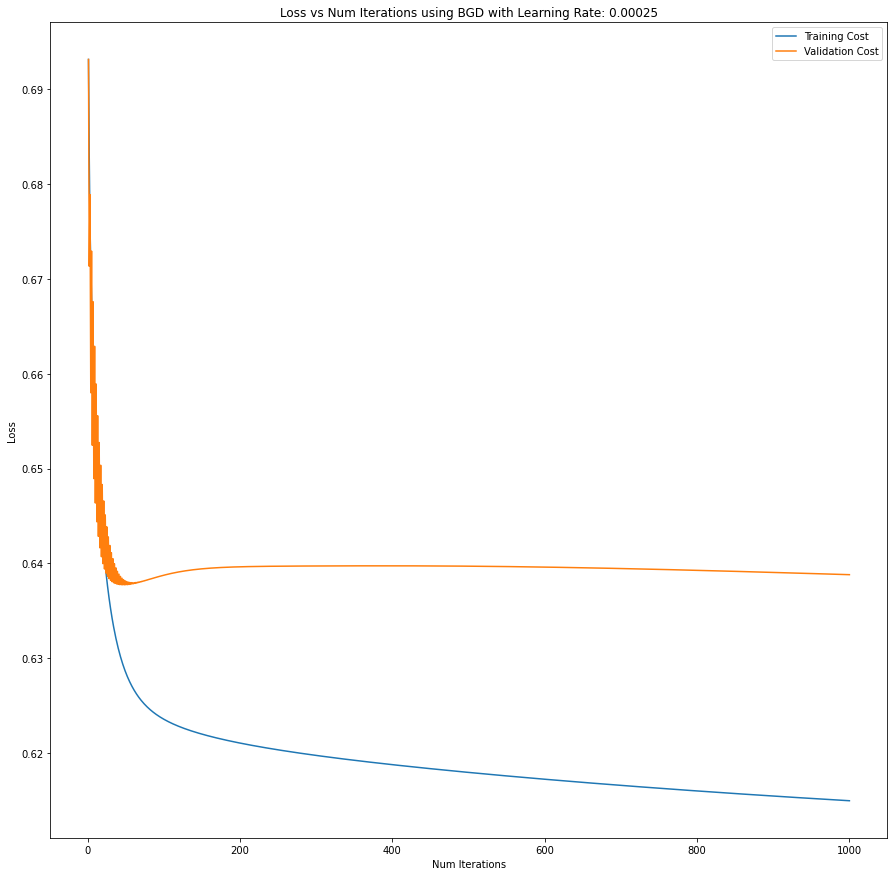

In [30]:
## 2.1 (a)

## using BGD

t.clear()
v.clear()

model = BGD(0.00025, 1000,x_train.shape[1],x_train.shape[0])
model.run_gd(x_train,y_train,x_val,y_val)

y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
print("Train Score:",score(y_train_pred,y_train), "Val Score:",score(y_val_pred,y_val), "Test Score:",score(y_test_pred,y_test))

print("y_train")
confusionMatrix(y_train,y_train_pred)
print("\ny_val")
confusionMatrix(y_val,y_val_pred)
print("\ny_test")
confusionMatrix(y_test,y_test_pred)

iterations = [i for i in range(1,len(t)+1)]
plt.plot(iterations,t,label="Training Cost")
plt.plot(iterations,v,label="Validation Cost")
plt.title("Loss vs Num Iterations using BGD with Learning Rate: 0.00025")
plt.xlabel("Num Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

iteration: 20 : 0.633410751919532
iteration: 40 : 0.6270611133855097
iteration: 60 : 0.6251209936694591
iteration: 80 : 0.6240941478053815
iteration: 100 : 0.6233687478346502
iteration: 120 : 0.6227878523481755
iteration: 140 : 0.6222926870495594
iteration: 160 : 0.6218543400721653
iteration: 180 : 0.6214563552708801
iteration: 200 : 0.6210886332691029
iteration: 220 : 0.6207446736410664
iteration: 240 : 0.620420129087322
iteration: 260 : 0.6201119874664659
iteration: 280 : 0.6198180887008303
iteration: 300 : 0.6195368309499211
iteration: 320 : 0.6192669875914227
iteration: 340 : 0.6190075907315531
iteration: 360 : 0.618757855489289
iteration: 380 : 0.6185171297330864
iteration: 400 : 0.6182848599880892
iteration: 420 : 0.6180605678004697
iteration: 440 : 0.6178438329896266
iteration: 460 : 0.617634281525435
iteration: 480 : 0.6174315765739531
iteration: 500 : 0.6172354117585978
iteration: 520 : 0.6170455060022569
iteration: 540 : 0.6168615995199032
iteration: 560 : 0.6166834506639424


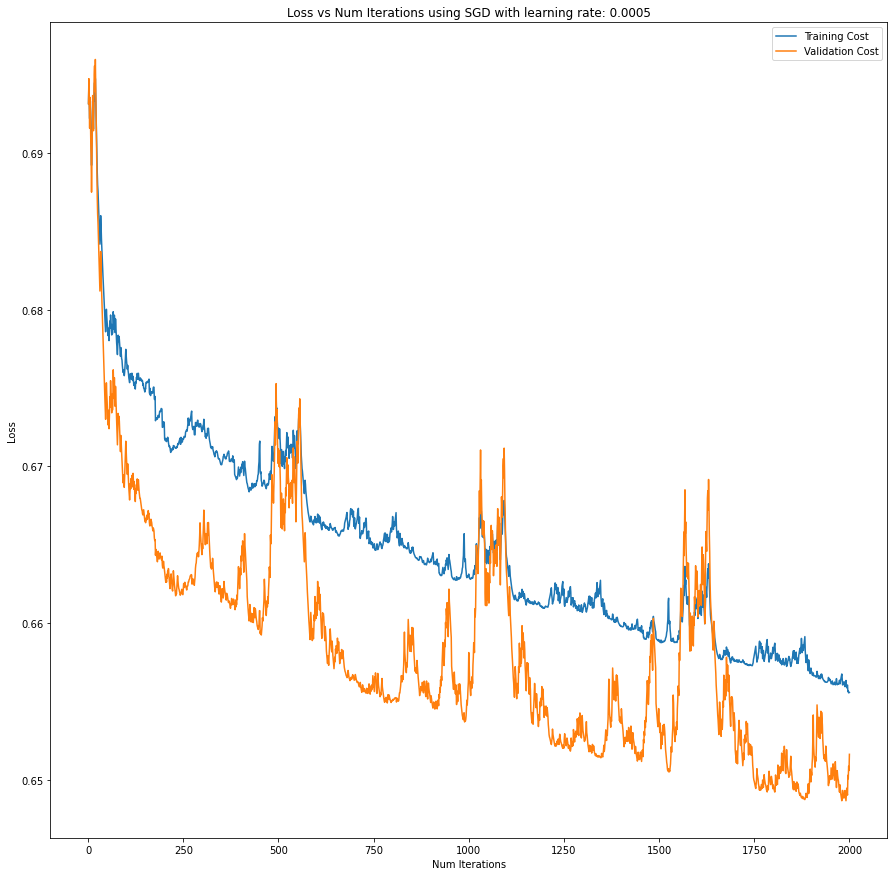

In [32]:
## using SGD

t.clear()
v.clear()

model = SGD(0.0005, 1000,x_train.shape[1],x_train.shape[0])
model.run_gd(x_train,y_train,x_val,y_val)

y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
print("Train Score:",score(y_train_pred,y_train), "Val Score:",score(y_val_pred,y_val), "Test Score:",score(y_test_pred,y_test))

print("y_train")
confusionMatrix(y_train,y_train_pred)
print("\ny_val")
confusionMatrix(y_val,y_val_pred)
print("\ny_test")
confusionMatrix(y_test,y_test_pred)

iterations = [i for i in range(1,len(t)+1)]
plt.plot(iterations,t,label="Training Cost")
plt.plot(iterations,v,label="Validation Cost")
plt.title("Loss vs Num Iterations using SGD with learning rate: 0.0005")
plt.xlabel("Num Iterations")
plt.ylabel("Loss")
#plt.ylim(0.6,0.8)
plt.legend()
plt.show()

iteration: 20 : 0.6548233508556175
iteration: 40 : 0.6447197997649011
iteration: 60 : 0.6381550553114947
iteration: 80 : 0.6337927771851135
iteration: 100 : 0.6308207965013911
iteration: 120 : 0.6287423987738688
iteration: 140 : 0.6272494699305046
iteration: 160 : 0.6261474971390792
iteration: 180 : 0.6253114518497651
iteration: 200 : 0.624659570353844
iteration: 220 : 0.6241375131775043
iteration: 240 : 0.6237086189873033
iteration: 260 : 0.6233477993867529
iteration: 280 : 0.6230376494373457
iteration: 300 : 0.6227659313010171
iteration: 320 : 0.6225239234488139
iteration: 340 : 0.6223053240703725
iteration: 360 : 0.6221055143615342
iteration: 380 : 0.621921058477572
iteration: 400 : 0.6217493608953854
iteration: 420 : 0.6215884295376598
iteration: 440 : 0.6214367106106056
iteration: 460 : 0.6212929724746729
iteration: 480 : 0.6211562232992579
iteration: 500 : 0.6210256521633014
Train Score: 0.6741154562383612 Val Score: 0.6688311688311688 Test Score: 0.7532467532467533
y_train
Confu

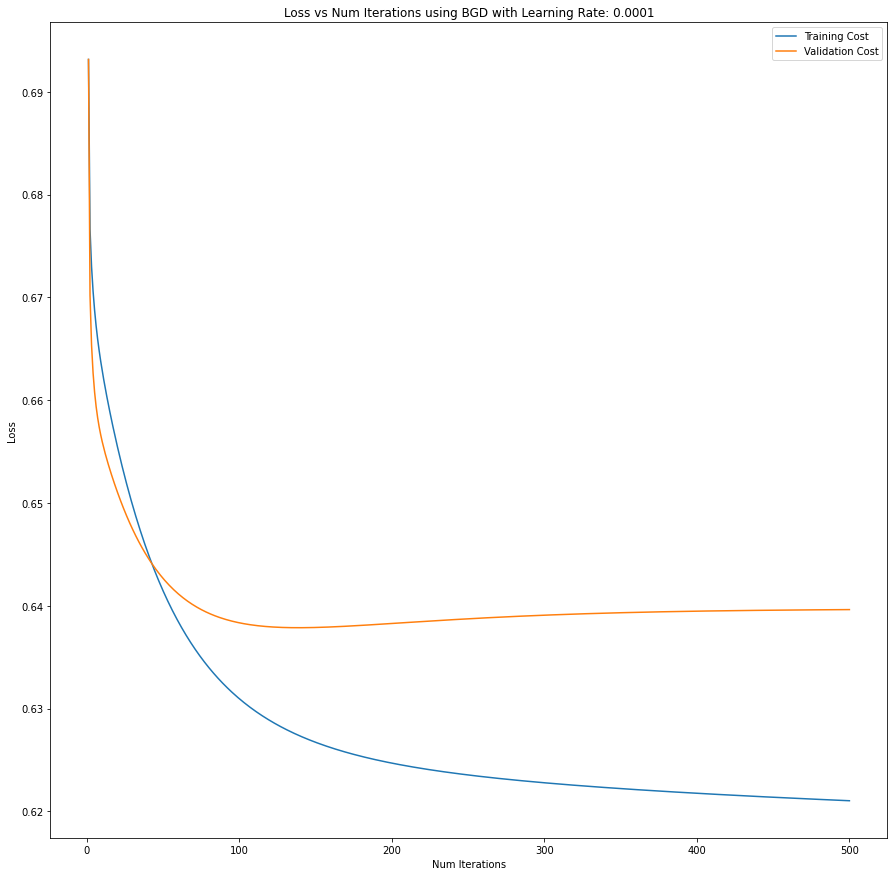

iteration: 20 : 11.37195107219289
iteration: 40 : 4.881117254383659
iteration: 60 : 36.7988293119101
iteration: 80 : 24.149311904776198
iteration: 100 : 26.553093616707606
iteration: 120 : 24.081946396236557
iteration: 140 : 23.834914251447593
iteration: 160 : 23.510440676971864
iteration: 180 : 23.668371959766173
iteration: 200 : 4.958851698341999
iteration: 220 : 5.005402310693216
iteration: 240 : 30.07603608707573
iteration: 260 : 16.411272595420776
iteration: 280 : 7.765450383285097
iteration: 300 : 24.178606195462052
iteration: 320 : 11.036760270399771
iteration: 340 : 10.550213702903662
iteration: 360 : 17.387646345959972
iteration: 380 : 23.58055407565142
iteration: 400 : 10.752982824249363
iteration: 420 : 23.80262705911461
iteration: 440 : 8.52264512356469
iteration: 460 : 7.7803205026353774
iteration: 480 : 20.349837111744232
iteration: 500 : 4.129316678510179
Train Score: 0.6945996275605214 Val Score: 0.6883116883116883 Test Score: 0.7012987012987013
y_train
Confusion Matrix

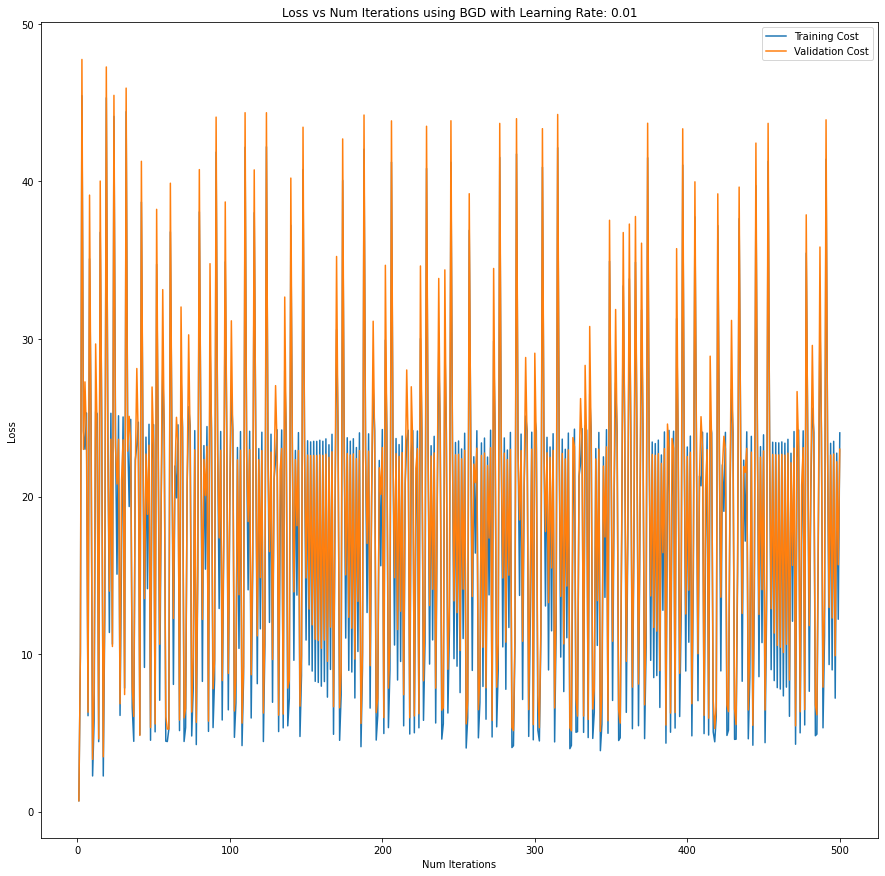

iteration: 20 : 25.38846617433459
iteration: 40 : 45.9916717084807
iteration: 60 : 25.122618360990785
iteration: 80 : 25.38846617433459
iteration: 100 : 25.388466174334596
iteration: 120 : 25.388466174334596
iteration: 140 : 43.33319357504251
iteration: 160 : 34.82606354804028
iteration: 180 : 25.388466174334596
iteration: 200 : 25.38846617433459
iteration: 220 : 24.856770547646956
iteration: 240 : 24.070325636424894
iteration: 260 : 44.54265932044492
iteration: 280 : 25.38846617433459
iteration: 300 : 24.85677054764696
iteration: 320 : 24.85677054764696
iteration: 340 : 25.255542267662683
iteration: 360 : 45.85874780180879
iteration: 380 : 24.72384664097513
iteration: 400 : 43.73196529841947
iteration: 420 : 44.39658482841778
iteration: 440 : 32.042978272097244
iteration: 460 : 32.34632052032796
iteration: 480 : 34.077708247277606
iteration: 500 : 25.25554226766269
Train Score: 0.6461824953445066 Val Score: 0.6493506493506493 Test Score: 0.6623376623376623
y_train
Confusion Matrix (TN

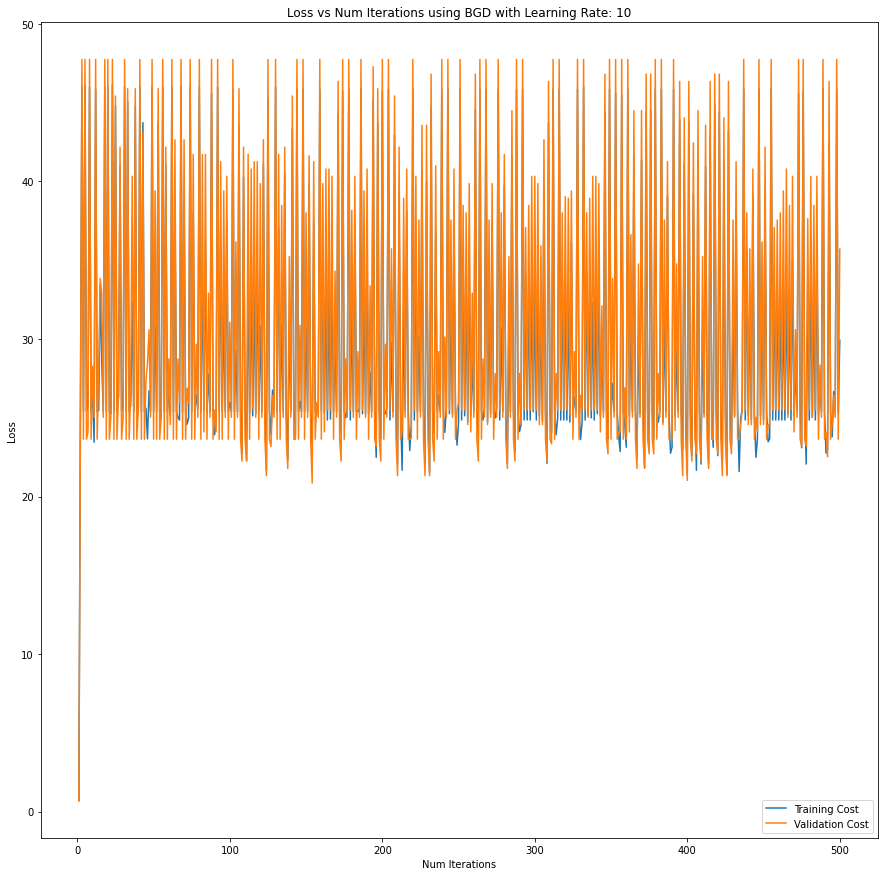

In [34]:
## 2.1 (b) and (c)

alphas = [0.0001,0.01,10]

## using BGD
for alpha in alphas:

    t.clear()
    v.clear()

    model = BGD(alpha, 500,x_train.shape[1],x_train.shape[0])
    model.run_gd(x_train,y_train,x_val,y_val)

    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    print("Train Score:",score(y_train_pred,y_train), "Val Score:",score(y_val_pred,y_val), "Test Score:",score(y_test_pred,y_test))
    
    print("y_train")
    confusionMatrix(y_train,y_train_pred)
    print("\ny_val")
    confusionMatrix(y_val,y_val_pred)
    print("\ny_test")
    confusionMatrix(y_test,y_test_pred)

    iterations = [i for i in range(1,len(t)+1)]
    plt.plot(iterations,t,label="Training Cost")
    plt.plot(iterations,v,label="Validation Cost")
    plt.title("Loss vs Num Iterations using BGD with Learning Rate: "+str(alpha))
    plt.xlabel("Num Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

iteration: 20 : 0.6550210907965
iteration: 40 : 0.6449091468340336
iteration: 60 : 0.6383334315451542
iteration: 80 : 0.6339568332416067
iteration: 100 : 0.6309712787850474
iteration: 120 : 0.6288814617472198
iteration: 140 : 0.6273794590611588
iteration: 160 : 0.6262704959110335
iteration: 180 : 0.625429159720626
iteration: 200 : 0.6247733125492215
iteration: 220 : 0.6242482952945355
iteration: 240 : 0.6238171900983019
iteration: 260 : 0.6234547097588214
iteration: 280 : 0.6231432986449577
iteration: 300 : 0.6228706064702687
iteration: 320 : 0.6226278288210289
iteration: 340 : 0.6224086034438598
iteration: 360 : 0.6222082679069667
iteration: 380 : 0.6220233552092171
iteration: 400 : 0.6218512478388915
iteration: 420 : 0.6216899384132447
iteration: 440 : 0.6215378626635694
iteration: 460 : 0.6213937819345816
iteration: 480 : 0.621256699830973
iteration: 500 : 0.6211258025818437
Train Score: 0.6685288640595903 Val Score: 0.6818181818181818 Test Score: 0.7532467532467533
y_train
Confusio

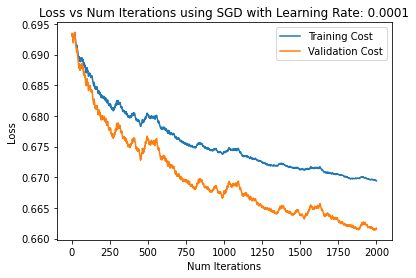

iteration: 20 : 0.6459596697602582
iteration: 40 : 0.6441612521503375
iteration: 60 : 0.6429230284439434
iteration: 80 : 0.6421621042709178
iteration: 100 : 0.6416571194289422
iteration: 120 : 0.6412716310936639
iteration: 140 : 0.6409351695039338
iteration: 160 : 0.6406139235133468
iteration: 180 : 0.6402928365445533
iteration: 200 : 0.6399660729160835
iteration: 220 : 0.6396321393565051
iteration: 240 : 0.6392914413197207
iteration: 260 : 0.638945089856659
iteration: 280 : 0.6385943439235173
iteration: 300 : 0.6382403707025324
iteration: 320 : 0.6378841608533368
iteration: 340 : 0.637526515630084
iteration: 360 : 0.6371680642645972
iteration: 380 : 0.6368092914095631
iteration: 400 : 0.6364505653582099
iteration: 420 : 0.6360921632243737
iteration: 440 : 0.6357342919104719
iteration: 460 : 0.6353771048913532
iteration: 480 : 0.6350207153214116
iteration: 500 : 0.6346652061052289
Train Score: 0.6554934823091247 Val Score: 0.6363636363636364 Test Score: 0.6883116883116883
y_train
Confu

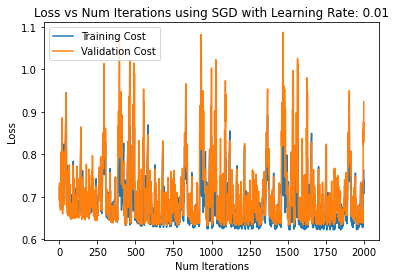

iteration: 20 : 39.13282537638306
iteration: 40 : 45.85874780180879
iteration: 60 : 19.278408801289824
iteration: 80 : 38.94810031381114
iteration: 100 : 41.80907743571028
iteration: 120 : 23.096576589984135
iteration: 140 : 23.56487577301649
iteration: 160 : 39.741722482448814
iteration: 180 : 21.053515190070186
iteration: 200 : 20.25339244669716
iteration: 220 : 39.63933638081424
iteration: 240 : 17.092868046543025
iteration: 260 : 26.156748091956317
iteration: 280 : 17.935677015826805
iteration: 300 : 20.59168278172835
iteration: 320 : 25.438155637099285
iteration: 340 : 18.36078089702963
iteration: 360 : 23.06391889338477
iteration: 380 : 39.33488738826602
iteration: 400 : 44.97343122966249
iteration: 420 : 45.65013731617539
iteration: 440 : 22.309491681545868
iteration: 460 : 23.614849241259304
iteration: 480 : 15.941614721810414
iteration: 500 : 21.63655388035423
Train Score: 0.6666666666666666 Val Score: 0.6493506493506493 Test Score: 0.6493506493506493
y_train
Confusion Matrix 

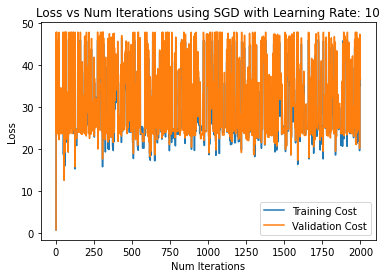

In [39]:
## 2.1 (b) and (c)

alphas = [0.0001,0.01,10]

## using SGD
for alpha in alphas:

    ## using SGD

    t.clear()
    v.clear()

    model = SGD(alpha,500,x_train.shape[1],x_train.shape[0])
    model.run_gd(x_train,y_train,x_val,y_val)

    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    print("Train Score:",score(y_train_pred,y_train), "Val Score:",score(y_val_pred,y_val), "Test Score:",score(y_test_pred,y_test))

    print("y_train")
    confusionMatrix(y_train,y_train_pred)
    print("\ny_val")
    confusionMatrix(y_val,y_val_pred)
    print("\ny_test")
    confusionMatrix(y_test,y_test_pred)
    
    iterations = [i for i in range(1,len(t)+1)]
    plt.plot(iterations,t,label="Training Cost")
    plt.plot(iterations,v,label="Validation Cost")
    plt.title("Loss vs Num Iterations using SGD with Learning Rate: "+str(alpha))
    plt.xlabel("Num Iterations")
    plt.ylabel("Loss")
    #plt.ylim(0,1)
    plt.legend()
    plt.show()


### 2.2 Running Inbuilt Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

model1 = LogisticRegression(max_iter=1000,verbose=1)
model1.fit(x_train,y_train)
y_train_pred=model.predict(x_train)
y_val_pred=model.predict(x_val)
y_test_pred=model.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [38]:
print("Train Score:",score(y_train_pred,y_train), "Val Score:",score(y_val_pred,y_val), "Test Score:",score(y_test_pred,y_test))

print("y_train")
confusionMatrix(y_train,y_train_pred)
print("\ny_val")
confusionMatrix(y_val,y_val_pred)
print("\ny_test")
confusionMatrix(y_test,y_test_pred)

Train Score: 0.6461824953445066 Val Score: 0.6493506493506493 Test Score: 0.6623376623376623
y_train
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[335  11]
 [179  12]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.65175097 0.96820809 0.77906977]
 [0.52173913 0.06282723 0.11214953]]

y_val
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[98  5]
 [49  2]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.66666667 0.95145631 0.784     ]
 [0.28571429 0.03921569 0.06896552]]

y_test
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[49  2]
 [24  2]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.67123288 0.96078431 0.79032258]
 [0.5        0.07692308 0.13333333]]


In [39]:
def cost_fun(y_pred, y):
        
    return np.sum(np.square(y-y_pred))/len(y)
    
train_cost = []
val_cost = []

for i in range(1,501):
    
    model = LogisticRegression(max_iter=i)
    model.fit(x_train,y_train)
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    
    train_cost.append(cost_fun(y_train_pred,y_train))
    val_cost.append(cost_fun(y_val_pred,y_val))
    

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hardeekh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

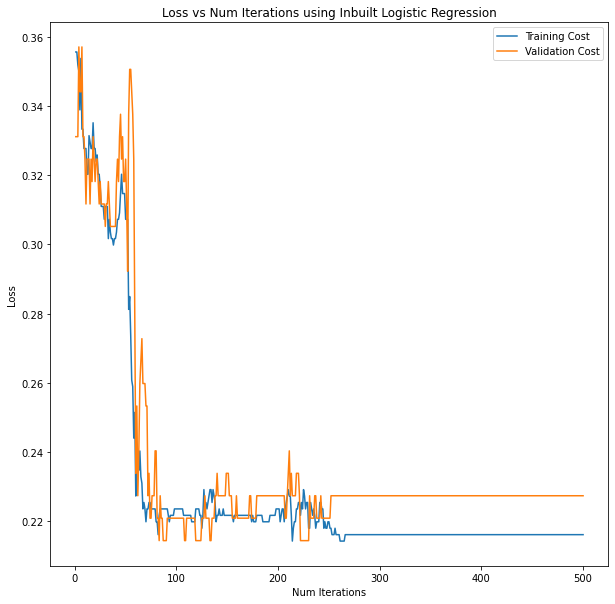

In [40]:
plt.rcParams["figure.figsize"] = (10,10)
iterations = [i for i in range(1,len(train_cost)+1)]
plt.plot(iterations,train_cost,label="Training Cost")
plt.plot(iterations,val_cost,label="Validation Cost")
plt.title("Loss vs Num Iterations using Inbuilt Logistic Regression")
plt.xlabel("Num Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [53]:
def cost_fun(y_pred, y):
        
    return np.sum(np.square(y-y_pred))/len(y)

from sklearn.linear_model import LogisticRegression, SGDClassifier

old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

model = SGDClassifier(alpha=0.005,verbose=1)
 
train_cost = []
val_cost = []

for i in range(500):
    
    model.partial_fit(x_train,y_train,classes=np.unique(y_train))
    y_train_pred=model.predict(x_train)
    y_val_pred=model.predict(x_val)
    y_test_pred=model.predict(x_test)
    
    train_cost.append(cost_fun(y_train_pred,y_train))
    val_cost.append(cost_fun(y_val_pred,y_val))    

In [54]:
sys.stdout = old_stdout
loss_history = mystdout.getvalue()

loss_list = []

for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))

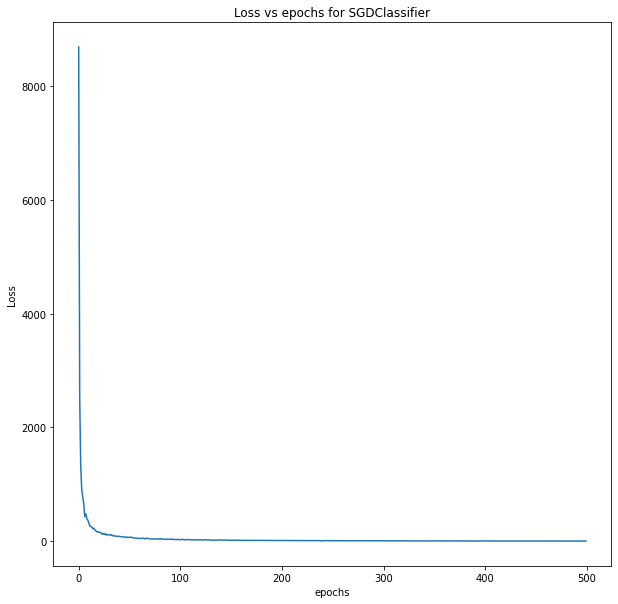

In [55]:
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("epochs"); plt.ylabel("Loss")
plt.title("Loss vs epochs for SGDClassifier (batch gradient descent)")
plt.show()

In [50]:
print("Train Score:",score(y_train_pred,y_train), "Val Score:",score(y_val_pred,y_val), "Test Score:",score(y_test_pred,y_test))

print("y_train")
confusionMatrix(y_train,y_train_pred)
print("\ny_val")
confusionMatrix(y_val,y_val_pred)
print("\ny_test")
confusionMatrix(y_test,y_test_pred)

Train Score: 0.6461824953445066 Val Score: 0.6428571428571429 Test Score: 0.6363636363636364
y_train
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[199 147]
 [ 43 148]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.82231405 0.57514451 0.67687075]
 [0.50169492 0.77486911 0.6090535 ]]

y_val
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[62 41]
 [14 37]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.81578947 0.60194175 0.69273743]
 [0.47435897 0.7254902  0.57364341]]

y_test
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[28 23]
 [ 5 21]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.84848485 0.54901961 0.66666667]
 [0.47727273 0.80769231 0.6       ]]


In [56]:
import sys
from io import StringIO
from sklearn.linear_model import LogisticRegression, SGDClassifier

old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

model1 = SGDClassifier(alpha=0.0001,loss="log",verbose=1)
model1.fit(x_train,y_train)
y_train_pred=model1.predict(x_train)
y_val_pred=model1.predict(x_val)
y_test_pred=model1.predict(x_test)

In [57]:
sys.stdout = old_stdout
loss_history = mystdout.getvalue()

loss_list = []

for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))

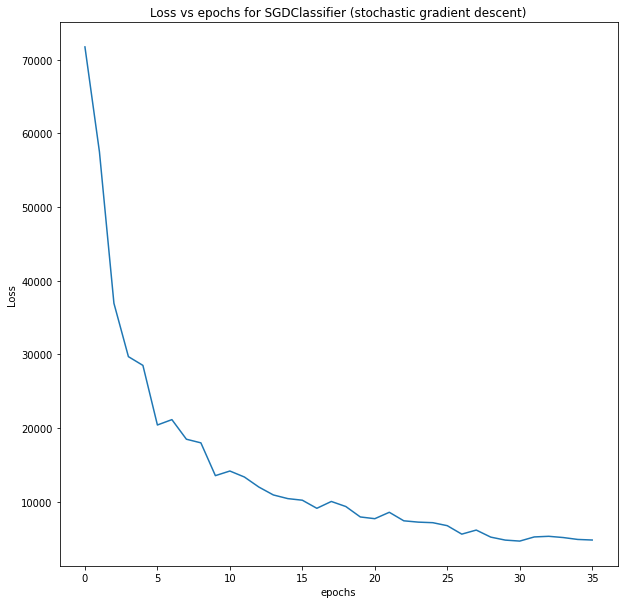

In [58]:
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("epochs"); plt.ylabel("Loss")
plt.title("Loss vs epochs for SGDClassifier (stochastic gradient descent)")
plt.show()

In [59]:
print("Train Score:",score(y_train_pred,y_train), "Val Score:",score(y_val_pred,y_val), "Test Score:",score(y_test_pred,y_test))

print("y_train")
confusionMatrix(y_train,y_train_pred)
print("\ny_val")
confusionMatrix(y_val,y_val_pred)
print("\ny_test")
confusionMatrix(y_test,y_test_pred)

Train Score: 0.6573556797020484 Val Score: 0.6298701298701299 Test Score: 0.7012987012987013
y_train
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[289  57]
 [127  64]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.69471154 0.83526012 0.75853018]
 [0.52892562 0.33507853 0.41025641]]

y_val
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[77 26]
 [31 20]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.71296296 0.74757282 0.72985782]
 [0.43478261 0.39215686 0.41237113]]

y_test
Confusion Matrix (TN,FP,TP,FN) clockwise from top-left:
 [[43  8]
 [15 11]]

Precision Recall F1-Score (1st row for label 0, 2nd row for label 1):
 [[0.74137931 0.84313725 0.78899083]
 [0.57894737 0.42307692 0.48888889]]
